# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass
from dotenv import load_dotenv

load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [4]:
# from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
# llm = ChatOpenAI(model="gpt-4o")
llm = ChatAnthropic(model='claude-haiku-4-5', temperature=0, max_tokens=1024)
llm.invoke(messages)

AIMessage(content="# Other Fascinating Ocean Mammals\n\nHere are some great ones to explore:\n\n**Pinnipeds** (seals, sea lions, walruses)\n- Highly adapted for diving and swimming\n- Interesting social behaviors, especially sea lions\n\n**Manatees and Dugongs**\n- Slow-moving herbivores\n- Surprisingly intelligent and gentle\n- Endangered in many regions\n\n**Dolphins and Porpoises**\n- Highly intelligent cetaceans\n- Complex social structures and communication\n- Often studied for cognition\n\n**Sea Otters**\n- Keystone species (their presence affects entire ecosystems)\n- Tool use and playful behavior\n- Fascinating relationship with sea urchins\n\n**Polar Bears**\n- Marine mammals despite being bears\n- Excellent swimmers\n- Climate change impacts their survival\n\n**Manatees** are particularly interesting if you want something less commonly discussed—they're gentle, slow, and face real conservation challenges.\n\nWhat aspect interests you most? Their behavior, ecology, conservatio

We can run our chat model in a simple graph with `MessagesState`.

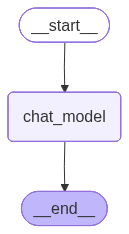

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

# Other Fascinating Ocean Mammals

Here are some great ones to explore:

**Pinnipeds** (seals, sea lions, walruses)
- Highly adapted for diving and swimming
- Interesting social behaviors, especially sea lions

**Manatees and Dugongs**
- Slow-moving herbivores
- Surprisingly intelligent and gentle
- Endangered in many regions

**Dolphins and Porpoises**
- Highly intelligent cetaceans
- Complex social structures and communication
- Often studied for cognition

**Sea Otters**
- Keystone species (their presence affects entire ecosystems)
- Tool use and playful behavior
- Fascinating relationship with sea urchins

**

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

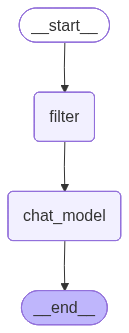

In [7]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

# Other Fascinating Ocean Mammals

Here are some great ones to explore:

**Pinnipeds** (seals, sea lions, walruses)
- Highly adapted for diving and swimming
- Interesting social behaviors, especially sea lions
- Walruses have unique tusks and Arctic adaptations

**Manatees and Dugongs**
- Slow-moving herbivores that graze on seagrass
- Surprisingly intelligent and gentle
- Endangered in many regions

**Dolphins and Porpoises**
- Highly intelligent and social
- Fascinating echolocation abilities
- Diverse species with different behaviors

**Sea Otters**
- Keystone species important to kelp forest ecosystems
- Tool

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

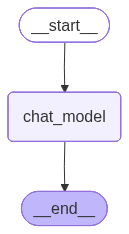

In [9]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [10]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [11]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

# Other Fascinating Ocean Mammals

Here are some great ones to explore:

**Pinnipeds** (seals, sea lions, walruses)
- Highly adapted for diving and swimming
- Interesting social behaviors, especially sea lions
- Walruses have unique tusks and Arctic adaptations

**Manatees and Dugongs**
- Slow-moving herbivores that graze on seagrass
- Surprisingly intelligent and gentle
- Endangered in many regions

**Dolphins and Porpois

In [12]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

# Other Fascinating Ocean Mammals

Here are some great ones to explore:

**Pinnipeds** (seals, sea lions, walruses)
- Highly adapted for diving and swimming
- Interesting social behaviors, especially sea lions
- Walruses have unique tusks and Arctic adaptations

**Manatees and Dugongs**
- Slow-moving herbivores that graze on seagrass
- Surprisingly intelligent and gentle
- Endangered in many regions

**Dolphins and Porpois

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

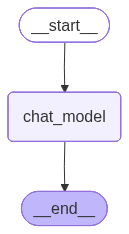

In [21]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatAnthropic(model_name="claude-haiku-4-5", max_tokens=1024, temperature=0),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [23]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatAnthropic(model_name="claude-haiku-4-5", max_tokens=1024, temperature=0),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [ ]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

## Comparison: Filtering vs Trimming

Let's compare both approaches side-by-side to understand when to use each.

Filtering is simpler and gives you exact control over which messages to include.
Trimming is more sophisticated and ensures you stay within token limits.

In [ ]:
# Create a longer conversation for comparison
comparison_messages = [
    AIMessage("Hi, I'm here to help with ocean mammals!", name="Bot", id="1"),
    HumanMessage("Great! Tell me about dolphins.", name="Lance", id="2"),
    AIMessage("Dolphins are highly intelligent marine mammals...", name="Bot", id="3"),
    HumanMessage("What about their social behavior?", name="Lance", id="4"),
    AIMessage("Dolphins live in complex social groups called pods...", name="Bot", id="5"),
    HumanMessage("Interesting! Now tell me about whale migration.", name="Lance", id="6")
]

print("FILTERING APPROACH - Last 2 messages only:")
print("=" * 50)
filtered = comparison_messages[-2:]
for m in filtered:
    m.pretty_print()

print("\n\nTRIMMING APPROACH - Token-based (max 100 tokens):")
print("=" * 50)
trimmed = trim_messages(
    comparison_messages,
    max_tokens=100,
    strategy="last",
    token_counter=ChatAnthropic(model_name="claude-haiku-4-5", max_tokens=1024, temperature=0),
    allow_partial=False
)
for m in trimmed:
    m.pretty_print()
